The lesson this week states that adding nonlinearity to an ANN actually hurts performance, likely due to overfitting.

Let's duplicate their results and verify overfitting is the culprit. 
Note: Many code samples are directly from the lesson at https://www.learnpytorch.io/03_pytorch_computer_vision/

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100.0%
100.0%
100.0%
100.0%


Number of training samples: 60000
Number of testing samples: 10000
Image shape: torch.Size([1, 28, 28])
Label: 9


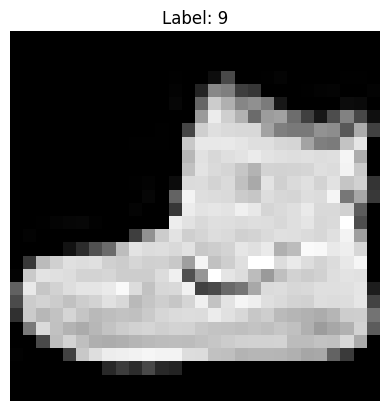

In [4]:
# verify shapes
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")
# Visualize some training data
image, label = train_data[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis(False)
plt.show()

In [67]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=TRAIN_BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fc50613abc0>, <torch.utils.data.dataloader.DataLoader object at 0x7fc50613bb20>)
Length of train dataloader: 235 batches of 256
Length of test dataloader: 40 batches of 256


In [7]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [64]:
import typing


def train_step(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer) -> typing.Tuple[typing.List[float], typing.List[float]]:
    train_losses, test_losses = [], []
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_pred = model(X_test)
            test_loss += loss_fn(y_test_pred, y_test).item()
    test_losses.append(test_loss / len(test_dataloader))

    epochs = 3
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(train_dataloader):
            print(f"Epoch: {epoch+1}/{epochs} | Batch: {batch+1}/{len(train_dataloader)}", end="\r")
            model.train()
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            model.eval()
            test_loss = 0
            with torch.inference_mode():
                for X_test, y_test in test_dataloader:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_test_pred = model(X_test)
                    test_loss += loss_fn(y_test_pred, y_test).item()
            test_losses.append(test_loss / len(test_dataloader))
        
            
    return train_losses, test_losses

In [53]:
def test_model(model: nn.Module, test_dataloader: DataLoader, loss_fn: nn.Module) -> typing.Tuple[float, float]:
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_pred = model(X_test)
            test_loss += loss_fn(y_test_pred, y_test).item()
            test_accuracy += (y_test_pred.argmax(dim=1) == y_test).sum().item()
    test_loss /= len(test_dataloader)
    assert test_dataloader.batch_size is not None
    test_accuracy /= (len(test_dataloader) * test_dataloader.batch_size)
    return test_loss, test_accuracy

In [85]:
def plot_losses(train_losses: typing.List[float], test_losses: typing.List[float]) -> None:
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title("Losses over time")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.ylim(0, 3)
    plt.legend()
    plt.show()

In [70]:
torch.manual_seed(42)
class_names = train_data.classes

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
)
model_0.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

train_losses, test_losses = train_step(model_0, train_dataloader, test_dataloader, loss_fn, optimizer)

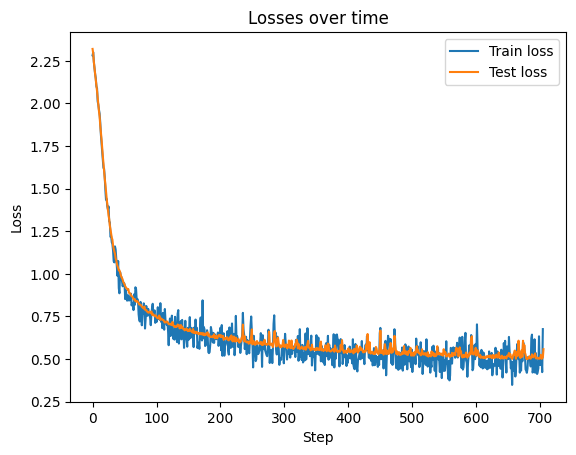

Final test loss: 0.5578, Final test accuracy: 0.7756
[2.319926953315735, 2.292700380086899, 2.243056833744049, 2.2063760459423065, 2.1731605172157287, 2.1413564026355743, 2.1043217539787293, 2.072025728225708, 2.031355857849121, 1.991797786951065, 1.9541015058755875, 1.9235900700092317, 1.8704095155000686, 1.8313200891017913, 1.790395939350128, 1.736969640851021, 1.6927532821893692, 1.6467613846063613, 1.6032687067985534, 1.5604573100805283, 1.526264700293541, 1.483448001742363, 1.4430147886276246, 1.4099186688661576, 1.371707707643509, 1.3423493564128877, 1.3203492164611816, 1.2826885432004929, 1.2611254721879959, 1.2353839784860612, 1.2115338087081908, 1.2012511759996414, 1.166525700688362, 1.1468899935483932, 1.131248989701271, 1.118850088119507, 1.091854801774025, 1.079387801885605, 1.0597957000136375, 1.0452481254935264, 1.0349833488464355, 1.0204782992601396, 1.0207300707697868, 1.0095849066972733, 0.9936099708080292, 0.9815416589379311, 0.9753407761454582, 0.9668799877166748, 0.

In [ ]:
plot_losses(train_losses, test_losses)
final_test_loss, final_test_accuracy = test_model(model_0, test_dataloader, loss_fn)
print(f"Final test loss: {final_test_loss:.4f}, Final test accuracy: {final_test_accuracy:.4f}")

In [72]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [73]:
torch.manual_seed(42)
class_names = train_data.classes

# Need to setup model with input parameters
model_1 = FashionMNISTModelV1(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
)
model_1.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

train_losses, test_losses = train_step(model_1, train_dataloader, test_dataloader, loss_fn, optimizer)

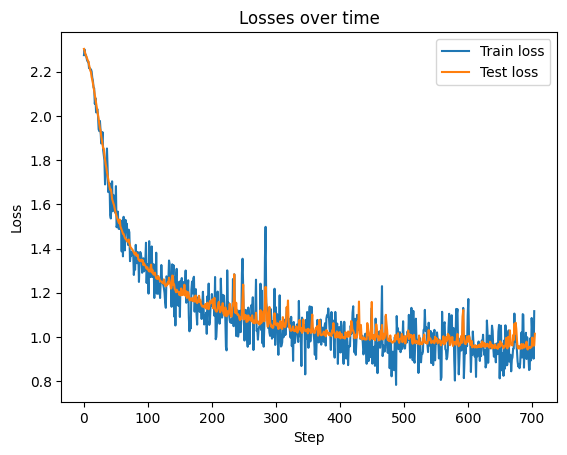

Final test loss: 1.0145, Final test accuracy: 0.6103
[2.3025263011455537, 2.2936080515384676, 2.2814771056175234, 2.273271358013153, 2.266712707281113, 2.2580840826034545, 2.250779688358307, 2.2438296377658844, 2.2304781436920167, 2.215021049976349, 2.2042665839195252, 2.1971063673496247, 2.1752278804779053, 2.1634687542915345, 2.147733300924301, 2.1302597522735596, 2.1120073020458223, 2.0945644080638885, 2.0747391879558563, 2.058611994981766, 2.037907662987709, 2.0192592203617097, 2.001759496331215, 1.9855607569217681, 1.9621542543172836, 1.9433040857315063, 1.9333249002695083, 1.9081445962190628, 1.8907888054847717, 1.873412588238716, 1.8540606260299684, 1.8522587358951568, 1.8225854337215424, 1.8018067538738252, 1.7808337479829788, 1.7651490300893784, 1.7441404849290847, 1.7309794157743454, 1.7136789500713348, 1.696215808391571, 1.679102972149849, 1.6651269227266312, 1.66802921295166, 1.6507118105888368, 1.6240244537591935, 1.6138689339160919, 1.6048347741365432, 1.5958401262760162,

In [ ]:
plot_losses(train_losses, test_losses)
final_test_loss, final_test_accuracy = test_model(model_1, test_dataloader, loss_fn)
print(f"Final test loss: {final_test_loss:.4f}, Final test accuracy: {final_test_accuracy:.4f}")

In [75]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [77]:
torch.manual_seed(42)
class_names = train_data.classes

# Need to setup model with input parameters
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
)
model_2.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

train_losses, test_losses = train_step(model_2, train_dataloader, test_dataloader, loss_fn, optimizer)

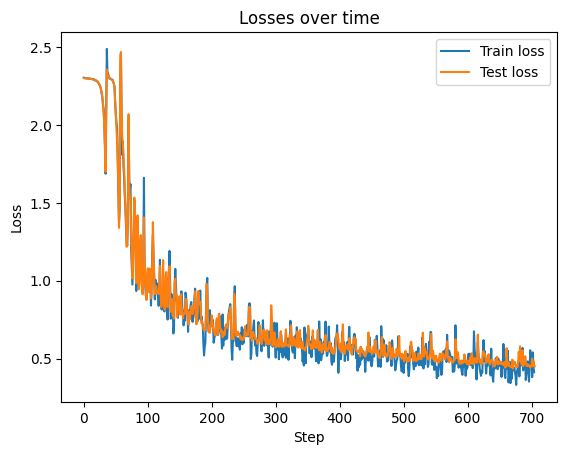

Final test loss: 0.4497, Final test accuracy: 0.8178


In [79]:
plot_losses(train_losses, test_losses)
final_test_loss, final_test_accuracy = test_model(model_2, test_dataloader, loss_fn)
print(f"Final test loss: {final_test_loss:.4f}, Final test accuracy: {final_test_accuracy:.4f}")

In [82]:
from torchvision.models import resnet18

# The resnet18 model is a pre-trained model that can be used for transfer learning.
model_v3 = resnet18(weights="DEFAULT")
print(model_v3)

# adjust the input layer to accept 1 channel (grayscale) images
model_v3.conv1 = nn.Conv2d(in_channels=1,
                                    out_channels=model_v3.conv1.out_channels,
                                    kernel_size=model_v3.conv1.kernel_size,
                                    stride=model_v3.conv1.stride,
                                    padding=model_v3.conv1.padding)
# adjust the output layer to match the number of classes in FashionMNIST
model_v3.fc = nn.Linear(in_features=model_v3.fc.in_features,
                                out_features=len(class_names))
# move the model to the target device
model_v3.to(device)

2.0%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mandzakjoshua/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [83]:
# train the model_v3 model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v3.parameters(), lr=0.1)
train_losses, test_losses = train_step(model_v3, train_dataloader, test_dataloader, loss_fn, optimizer)

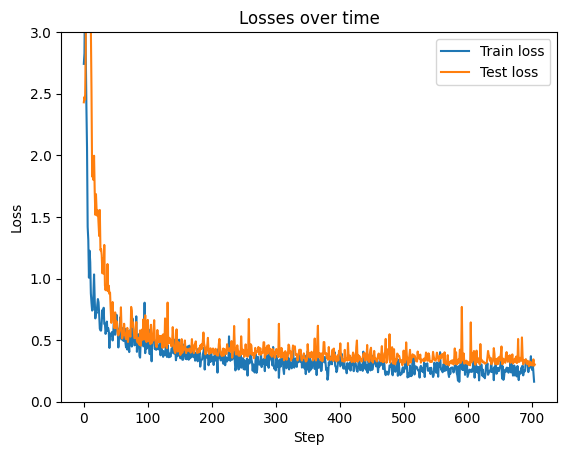

Final test loss: 0.3024, Final test accuracy: 0.8673


In [86]:
plot_losses(train_losses, test_losses)
final_test_loss, final_test_accuracy = test_model(model_v3, test_dataloader, loss_fn)
print(f"Final test loss: {final_test_loss:.4f}, Final test accuracy: {final_test_accuracy:.4f}")